In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import os

import shutil

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from torch.utils.data import Dataset, DataLoader
import pandas as pd

from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
from PIL import Image
import os

Знайдено 100 класів: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ARCIGERA FLOWER MOTH', 'ATALA', 'ATLAS MOTH', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BANDED TIGER MOTH', 'BECKERS WHITE', 'BIRD CHERRY ERMINE MOTH', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CINNABAR MOTH', 'CLEARWING MOTH', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMET MOTH', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'EMPEROR GUM MOTH', 'GARDEN TIGER MOTH', 'GIANT LEOPARD MOTH', 'GLITTERING SAPPHIRE', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREEN HAIRSTREAK', 'GREY HAIRSTREAK', 'HERCULES MOTH', 'HUMMING BIRD HAWK MOTH', 'INDRA SWALLOW', 'I

/tmp/ipython-input-326220124.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_counts.keys()), y=list(sorted_counts.values()), palette='viridis')


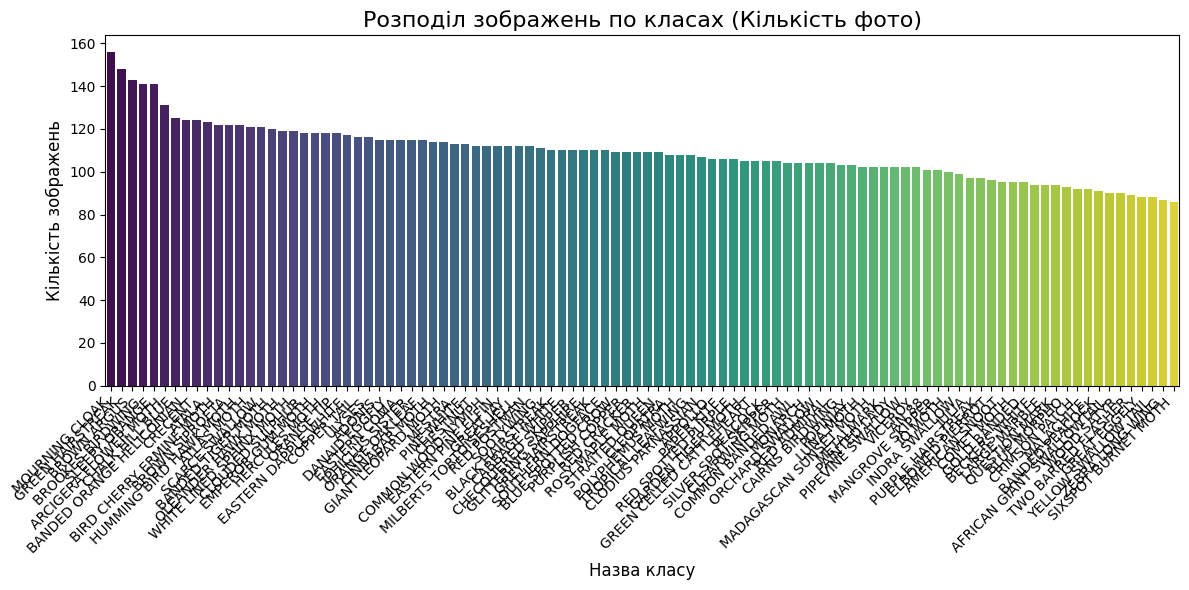

In [ ]:
data_dir = Path('fast_data/train')


classes = [d.name for d in data_dir.iterdir() if d.is_dir() and not d.name.startswith('.')]
classes.sort() # Сортуємо за алфавітом

print(f"Знайдено {len(classes)} класів: {classes}")


class_counts = {}

for class_name in classes:
    class_path = data_dir / class_name
    count = len([f for f in class_path.glob('*') if f.is_file()])
    class_counts[class_name] = count

sorted_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
sns.barplot(x=list(sorted_counts.keys()), y=list(sorted_counts.values()), palette='viridis')
plt.title('Розподіл зображень по класах (Кількість фото)', fontsize=16)
plt.xlabel('Назва класу', fontsize=12)
plt.ylabel('Кількість зображень', fontsize=12)
plt.xticks(rotation=45, ha='right') # Повертаємо підписи, щоб не накладалися
plt.tight_layout()
plt.show()

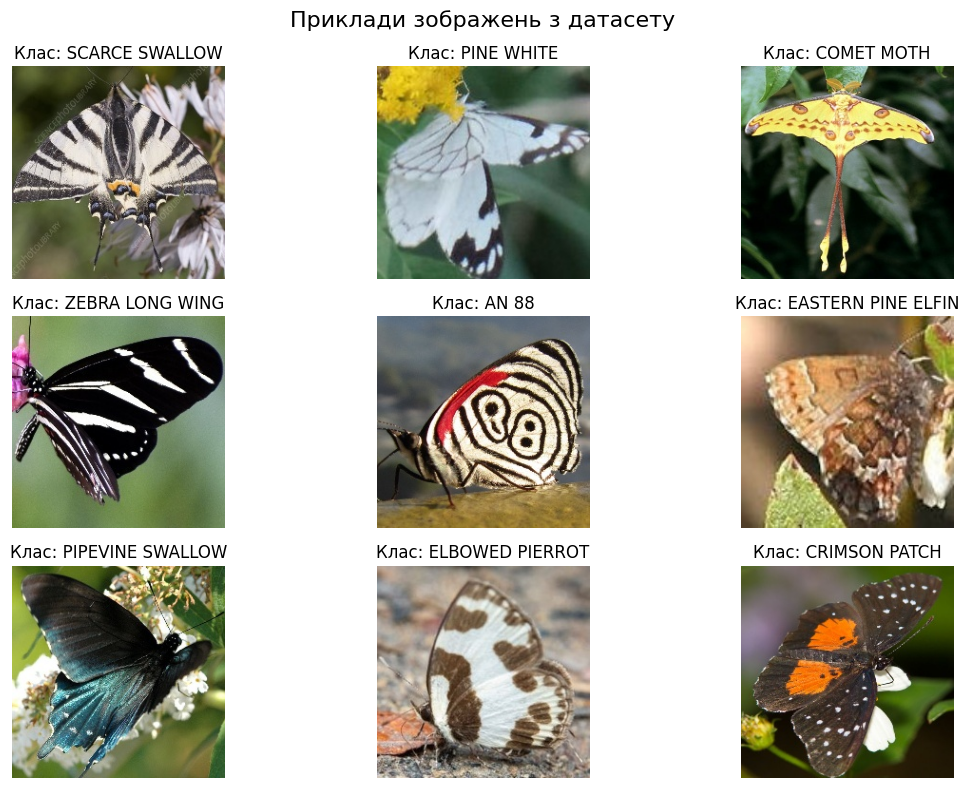

In [ ]:
def show_random_images(num_images=9):
    plt.figure(figsize=(12, 8))

    sample_classes = random.choices(classes, k=num_images) if len(classes) < num_images else random.sample(classes, num_images)

    for i, class_name in enumerate(sample_classes):
        class_path = data_dir / class_name
        images = list(class_path.glob('*'))

        if not images:
            continue

        random_image_path = random.choice(images)
        img = Image.open(random_image_path)

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Клас: {class_name}")
        plt.axis('off') 
    plt.suptitle('Приклади зображень з датасету', fontsize=16)
    plt.tight_layout()
    plt.show()


show_random_images(9)

In [3]:
!pip install ultralytics -q
import ultralytics
from ultralytics import YOLO

# Перевірка
ultralytics.checks()

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.8/112.6 GB disk)


In [ ]:
#!unzip -q /content/lnu-deep-learn-1-image-classification-2025.zip -d /content/fast_data

#!rm /content/lnu-deep-learn-1-image-classification-2025.zip

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Використовуємо пристрій: {device}")
if device.type == 'cuda':
    print(f"Назва відеокарти: {torch.cuda.get_device_name(0)}")

data_dir = 'fast_data'
train_dir = os.path.join(data_dir, 'train')

Використовуємо пристрій: cuda
Назва відеокарти: Tesla T4


In [ ]:

os.chdir('/content')


print("Поточна папка:", os.getcwd())
print("Вміст папки:", os.listdir())

Поточна папка: /content
Вміст папки: ['.config', 'fast_data']


In [ ]:
classes_path = os.path.join(data_dir, 'classes.txt')

with open(classes_path, 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

num_classes = len(class_names)

print(f"Кількість класів: {num_classes}")
print(f"Перші 5 класів для прикладу: {class_names[:5]}")

Кількість класів: 100
Перші 5 класів для прикладу: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO']


In [ ]:
data_path = '/content/fast_data'

train_path = os.path.join(data_path, 'train')
if os.path.exists(train_path):
    classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
    num_classes = len(classes)
    print(f"✅ Шлях до даних встановлено: {data_path}")
    print(f"Кількість класів: {num_classes}")
else:
    print("❌ Увага! Папка train не знайдена. Перевірте шлях.")

✅ Шлях до даних встановлено: /content/fast_data
Кількість класів: 100


In [4]:
!pip install mlflow
import mlflow
import os

In [5]:
import random
import yaml

In [ ]:
source_dir = '/content/fast_data/train'
dataset_root = '/content/dataset_split'
project_dir = "/content/yolo_tuning"
final_config_path = os.path.join(project_dir, 'final_config.yaml')


TUNE_ITERATIONS = 2    
TUNE_EPOCHS = 5       


FIXED_AUGMENTATIONS = {
    'imgsz': 224,
    'degrees': 10.0,      # Поворот +/- 10 град
    'translate': 0.1,     # Зсув
    'scale': 0.9,         # Масштабування
    'shear': 0.0,         # Викривлення (вимкнено)
    'perspective': 0.0,   # Перспектива (вимкнено)
    'flipud': 0.0,        # Вертикальний фліп (вимкнено)
    'fliplr': 0.5,        # Горизонтальний фліп (50%)
    'mosaic': 0.0,        # Mosaic (вимкнено)
    'mixup': 0.0,         # Mixup (вимкнено)
    'hsv_h': 0.015,       # Колір
    'hsv_s': 0.4,
    'hsv_v': 0.4,
}


print("✂️ КРОК 1: Розбиваємо дані на TRAIN (80%) та VAL (20%)...")

if os.path.exists(dataset_root):
    shutil.rmtree(dataset_root)

classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

for cls in classes:
    os.makedirs(os.path.join(dataset_root, 'train', cls), exist_ok=True)
    os.makedirs(os.path.join(dataset_root, 'val', cls), exist_ok=True)

    src_cls_dir = os.path.join(source_dir, cls)
    files = [f for f in os.listdir(src_cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(files)

    split_idx = int(len(files) * 0.8)
    # Захист від пустих папок
    if split_idx == 0 and len(files) > 0: split_idx = 1

    for f in files[:split_idx]:
        os.symlink(os.path.join(src_cls_dir, f), os.path.join(dataset_root, 'train', cls, f))
    for f in files[split_idx:]:
        os.symlink(os.path.join(src_cls_dir, f), os.path.join(dataset_root, 'val', cls, f))

print(f"✅ Дані підготовлено у: {dataset_root}")


print(f"\n🧬 КРОК 2: Починаємо підбір LR, Momentum, Weight Decay...")
print("MLflow тут вимкнено. Аугментації зафіксовані аргументами.")

model = YOLO('yolo11s-cls.pt')


tuning_results = model.tune(
    data=dataset_root,
    epochs=TUNE_EPOCHS,
    iterations=TUNE_ITERATIONS,
    optimizer='AdamW',
    project=project_dir,
    name='tune_run',
    plots=False,
    save=False,
    val=True,
    exist_ok=True,
    verbose=True,
    **FIXED_AUGMENTATIONS  
)


print("\n💾 КРОК 3: Формування та збереження фінального конфігу...")

final_params = {}
tuned_params = None


if tuning_results and isinstance(tuning_results, dict):
    print("✅ Параметри отримано з результату виконання функції (з пам'яті).")
    tuned_params = tuning_results


if not tuned_params:
    if os.path.exists(project_dir):
        subdirs = [os.path.join(project_dir, d) for d in os.listdir(project_dir) if os.path.isdir(os.path.join(project_dir, d)) and 'tune' in d]
        subdirs.sort(key=os.path.getmtime, reverse=True) # Сортуємо за часом, найновіші перші

        if subdirs:
            latest_run_dir = subdirs[0]
            possible_yaml = os.path.join(latest_run_dir, 'best_hyperparameters.yaml')
            print(f"🔎 Шукаємо файл у: {possible_yaml}")

            if os.path.exists(possible_yaml):
                with open(possible_yaml, 'r') as f:
                    tuned_params = yaml.safe_load(f)
                print("✅ Параметри зчитано з файлу!")


if tuned_params:
    print("Знайдені оптимізовані параметри:")
    target_keys = ['lr0', 'lrf', 'momentum', 'weight_decay', 'warmup_epochs', 'warmup_momentum']

    for k in target_keys:
        if k in tuned_params:
            final_params[k] = tuned_params[k]
            print(f"  -> {k}: {tuned_params[k]}")
else:
    print("⚠️ УВАГА: Результати тюнінгу не знайдено ні в пам'яті, ні у файлах.")
    print("Використовуємо рекомендовані дефолтні параметри для AdamW.")
    final_params = {'lr0': 0.001, 'lrf': 0.01, 'momentum': 0.9, 'weight_decay': 0.0005}


final_params.update(FIXED_AUGMENTATIONS)


with open(final_config_path, 'w') as f:
    yaml.dump(final_params, f)

print(f"\n✅ Фінальний конфіг збережено: {final_config_path}")
print("-" * 20)
print(final_params)
print("-" * 20)

✂️ КРОК 1: Розбиваємо дані на TRAIN (80%) та VAL (20%)...
✅ Дані підготовлено у: /content/dataset_split

🧬 КРОК 2: Починаємо підбір LR, Momentum, Weight Decay...
MLflow тут вимкнено. Аугментації зафіксовані аргументами.
Tuner: Initialized Tuner instance with 'tune_dir=/content/yolo_tuning/tune_run3'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/2 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.4, 'hsv_v': 0.4, 'degrees': 10.0, 'translate': 0.1, 'scale': 0.9, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 0.0, 'mixup': 0.0, 'cutmix': 0.0, 'copy_paste': 0.0, 'close_mosaic': 10}
Saved /content/yolo_tuning/tune_run3/tune_scatter_plots.png
Saved /content/yolo_tuning/tune_run3/tune_fitness.png

Tuner: 1/2 iterations complete ✅ (328.1

In [ ]:
from sklearn.model_selection import StratifiedKFold


source_dir = '/content/fast_data/train'
project_dir = "/content/yolo_incremental_stratified"
final_config_path = "/content/yolo_tuning/final_config.yaml"

K_FOLDS = 10
EPOCHS_PER_FOLD = 1
IMG_SIZE = 224


if os.path.exists(final_config_path):
    with open(final_config_path, 'r') as f:
        best_params = yaml.safe_load(f)
else:
    print("⚠️ Конфіг не знайдено, беремо дефолтні.")
    best_params = {'lr0': 0.001, 'degrees': 10.0, 'fliplr': 0.5, 'mosaic': 1.0}


valid_args = ['lr0', 'lrf', 'momentum', 'weight_decay', 'degrees', 'translate', 'scale', 'fliplr', 'mosaic', 'mixup', 'hsv_h', 'hsv_s', 'hsv_v']
filtered_params = {k: v for k, v in best_params.items() if k in valid_args}

print("🗂️ Збираємо файли...")
all_files = []
all_labels = []
classes = sorted([d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))])
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

for cls in classes:
    cls_dir = os.path.join(source_dir, cls)
    files = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    all_files.extend(files)
    all_labels.extend([class_to_idx[cls]] * len(files)) # Цифрові мітки потрібні для StratifiedKFold

all_files = np.array(all_files)
all_labels = np.array(all_labels)


skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)


current_model_path = 'yolo11s-cls.pt'
temp_fold_data = '/content/current_fold_data'

print(f"🚀 Починаємо ланцюжкове тренування на {K_FOLDS} фолдів...")

for fold_index, (train_idx, val_idx) in enumerate(skf.split(all_files, all_labels)):
    fold_num = fold_index + 1
    print(f"\n🔄 --- FOLD {fold_num}/{K_FOLDS} ---")
    print(f"📥 Завантажуємо ваги з: {current_model_path}")


    if os.path.exists(temp_fold_data): shutil.rmtree(temp_fold_data)


    for file_path in all_files[train_idx]:
        cls_name = os.path.basename(os.path.dirname(file_path))
        target_dir = os.path.join(temp_fold_data, 'train', cls_name)
        os.makedirs(target_dir, exist_ok=True)
        os.symlink(file_path, os.path.join(target_dir, os.path.basename(file_path)))


    for file_path in all_files[val_idx]:
        cls_name = os.path.basename(os.path.dirname(file_path))
        target_dir = os.path.join(temp_fold_data, 'val', cls_name)
        os.makedirs(target_dir, exist_ok=True)
        os.symlink(file_path, os.path.join(target_dir, os.path.basename(file_path)))


    model = YOLO(current_model_path)


    results = model.train(
        data=temp_fold_data,
        epochs=EPOCHS_PER_FOLD,  # 10 епох
        imgsz=IMG_SIZE,
        batch=64,
        project=project_dir,
        name=f'fold_{fold_num}',
        device=0,
        exist_ok=True,
        verbose=True, 
        **filtered_params
    )


    current_model_path = os.path.join(project_dir, f'fold_{fold_num}', 'weights', 'best.pt')

    print(f"✅ Fold {fold_num} завершено. Ваги збережено для наступного етапу.")

print("\n🏆 Ланцюжкове навчання завершено!")
print(f"Фінальна модель (найрозумніша): {current_model_path}")

🗂️ Збираємо файли...
🚀 Починаємо ланцюжкове тренування на 10 фолдів...

🔄 --- FOLD 1/10 ---
📥 Завантажуємо ваги з: yolo11s-cls.pt
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/current_fold_data, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-cls.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=fold_1, nb

/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/11/27 23:15:05 INFO mlflow.tracking.fluent: Experiment with name '/content/yolo_incremental_stratified' does not exist. Creating a new experiment.
2025/11/27 23:15:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:15:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:15:12 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:15:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(eb39612b14614a38950abd6b78d1e531) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified/fold_1
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.55G      4.597         27        224: 100% ━━━━━━━━━━━━ 154/154 2.9it/s 53.8s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 3.2it/s 2.8s
                   all      0.103      0.261

1 epochs completed in 0.016 hours.
Optimizer stripped from /content/yolo_incremental_stratified/fold_1/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified/fold_1/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified/fold_1/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CU

2025/11/27 23:16:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:16:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:16:23 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:16:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(86d0235c7d934423b75754c7ba640913) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified/fold_2
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.59G      3.993         28        224: 100% ━━━━━━━━━━━━ 154/154 2.7it/s 57.6s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 2.8it/s 3.2s
                   all      0.418        0.7

1 epochs completed in 0.018 hours.
Optimizer stripped from /content/yolo_incremental_stratified/fold_2/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified/fold_2/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified/fold_2/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CU

2025/11/27 23:17:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:17:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:17:38 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:17:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(94ae7ac6bc02466a9b623646b21d1a2f) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified/fold_3
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.54G      3.187         28        224: 100% ━━━━━━━━━━━━ 154/154 2.9it/s 52.7s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 5.4it/s 1.7s
                   all      0.625      0.863

1 epochs completed in 0.016 hours.
Optimizer stripped from /content/yolo_incremental_stratified/fold_3/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified/fold_3/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified/fold_3/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CU

2025/11/27 23:18:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:18:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:18:48 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:18:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(55b5e39d2de14402834c3d75ab222314) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified/fold_4
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.61G      2.395         28        224: 100% ━━━━━━━━━━━━ 154/154 2.9it/s 52.5s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 5.3it/s 1.7s
                   all      0.748       0.93

1 epochs completed in 0.017 hours.
Optimizer stripped from /content/yolo_incremental_stratified/fold_4/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified/fold_4/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified/fold_4/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CU

2025/11/27 23:20:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:20:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:20:00 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:20:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(fc0a4d8af41d4d53a8bdd59f39d47930) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified/fold_5
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.61G      1.806         28        224: 100% ━━━━━━━━━━━━ 154/154 3.0it/s 52.1s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 3.8it/s 2.4s
                   all       0.82      0.951

1 epochs completed in 0.016 hours.
Optimizer stripped from /content/yolo_incremental_stratified/fold_5/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified/fold_5/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified/fold_5/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CU

2025/11/27 23:21:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:21:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:21:11 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:21:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(e09a7e8f197f4a85a8a12a5bdb088285) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified/fold_6
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.61G      1.404         28        224: 100% ━━━━━━━━━━━━ 154/154 2.9it/s 53.1s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 5.7it/s 1.6s
                   all      0.835      0.956

1 epochs completed in 0.016 hours.
Optimizer stripped from /content/yolo_incremental_stratified/fold_6/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified/fold_6/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified/fold_6/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CU

2025/11/27 23:22:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:22:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:22:22 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:22:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(777cfb7f36f14c4e87619689b6ba8c78) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified/fold_7
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.59G      1.115         28        224: 100% ━━━━━━━━━━━━ 154/154 2.8it/s 54.6s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 3.8it/s 2.4s
                   all       0.86      0.967

1 epochs completed in 0.017 hours.
Optimizer stripped from /content/yolo_incremental_stratified/fold_7/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified/fold_7/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified/fold_7/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CU

2025/11/27 23:23:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:23:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:23:35 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:23:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(263bb9f370db4044b40c5b4e0ad59d22) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified/fold_8
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.61G     0.9375         28        224: 100% ━━━━━━━━━━━━ 154/154 2.9it/s 53.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s
                   all      0.898      0.984

1 epochs completed in 0.016 hours.
Optimizer stripped from /content/yolo_incremental_stratified/fold_8/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified/fold_8/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified/fold_8/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CU

2025/11/27 23:24:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:24:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:24:47 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:24:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(3bc918837d644d668c2aa2b58ecda9f3) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified/fold_9
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.61G     0.8099         28        224: 100% ━━━━━━━━━━━━ 154/154 2.9it/s 52.4s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 5.6it/s 1.6s
                   all      0.906       0.98

1 epochs completed in 0.017 hours.
Optimizer stripped from /content/yolo_incremental_stratified/fold_9/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified/fold_9/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified/fold_9/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CU

2025/11/27 23:25:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:25:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:25:58 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:25:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(100abad0474b4615912a76be82d39cd7) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified/fold_10
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.53G     0.7132         28        224: 100% ━━━━━━━━━━━━ 154/154 2.8it/s 54.6s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 5.4it/s 1.7s
                   all      0.895      0.978

1 epochs completed in 0.017 hours.
Optimizer stripped from /content/yolo_incremental_stratified/fold_10/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified/fold_10/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified/fold_10/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu12

In [ ]:
source_dir = '/content/fast_data/train'


start_weights = "/content/yolo_incremental_stratified/fold_10/weights/best.pt"


project_dir = "/content/yolo_incremental_stratified_round2"
final_config_path = "/content/yolo_tuning/final_config.yaml"

K_FOLDS = 10
EPOCHS_PER_FOLD = 1
IMG_SIZE = 224


if os.path.exists(final_config_path):
    with open(final_config_path, 'r') as f:
        best_params = yaml.safe_load(f)
else:
    best_params = {'lr0': 0.001, 'degrees': 10.0, 'fliplr': 0.5, 'mosaic': 1.0}


best_params['lr0'] = best_params.get('lr0', 0.001) / 2.0
print(f"📉 Learning Rate зменшено до {best_params['lr0']} для тонкого донавчання.")

valid_args = ['lr0', 'lrf', 'momentum', 'weight_decay', 'degrees', 'translate', 'scale', 'fliplr', 'mosaic', 'mixup', 'hsv_h', 'hsv_s', 'hsv_v']
filtered_params = {k: v for k, v in best_params.items() if k in valid_args}


all_files = []
all_labels = []
classes = sorted([d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))])
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

for cls in classes:
    cls_dir = os.path.join(source_dir, cls)
    files = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    all_files.extend(files)
    all_labels.extend([class_to_idx[cls]] * len(files))

all_files = np.array(all_files)
all_labels = np.array(all_labels)


skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42) # Той самий random_state гарантує ті самі фолди


current_model_path = start_weights
temp_fold_data = '/content/current_fold_data_round2'

print(f"🚀 Починаємо РАУНД 2 (ще 10 епох на фолд)...")
print(f"🏁 Стартова точка: {current_model_path}")

for fold_index, (train_idx, val_idx) in enumerate(skf.split(all_files, all_labels)):
    fold_num = fold_index + 1
    print(f"\n🔄 --- ROUND 2 | FOLD {fold_num}/{K_FOLDS} ---")


    if os.path.exists(temp_fold_data): shutil.rmtree(temp_fold_data)


    for file_path in all_files[train_idx]:
        cls_name = os.path.basename(os.path.dirname(file_path))
        target_dir = os.path.join(temp_fold_data, 'train', cls_name)
        os.makedirs(target_dir, exist_ok=True)
        os.symlink(file_path, os.path.join(target_dir, os.path.basename(file_path)))


    for file_path in all_files[val_idx]:
        cls_name = os.path.basename(os.path.dirname(file_path))
        target_dir = os.path.join(temp_fold_data, 'val', cls_name)
        os.makedirs(target_dir, exist_ok=True)
        os.symlink(file_path, os.path.join(target_dir, os.path.basename(file_path)))

    print(f"📥 Loading weights: {current_model_path}")
    model = YOLO(current_model_path)

    results = model.train(
        data=temp_fold_data,
        epochs=EPOCHS_PER_FOLD,
        imgsz=IMG_SIZE,
        batch=64,
        project=project_dir,
        name=f'fold_{fold_num}',
        device=0,
        exist_ok=True,
        verbose=True,
        **filtered_params
    )


    current_model_path = os.path.join(project_dir, f'fold_{fold_num}', 'weights', 'best.pt')
    print(f"✅ Round 2 Fold {fold_num} завершено.")

print("\n🏆 РАУНД 2 ЗАВЕРШЕНО!")
print(f"Супер-фінальна модель: {current_model_path}")

📉 Learning Rate зменшено до 0.005 для тонкого донавчання.
🚀 Починаємо РАУНД 2 (ще 10 епох на фолд)...
🏁 Стартова точка: /content/yolo_incremental_stratified/fold_10/weights/best.pt

🔄 --- ROUND 2 | FOLD 1/10 ---
📥 Loading weights: /content/yolo_incremental_stratified/fold_10/weights/best.pt
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/current_fold_data_round2, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, li

2025/11/27 23:27:10 INFO mlflow.tracking.fluent: Experiment with name '/content/yolo_incremental_stratified_round2' does not exist. Creating a new experiment.
2025/11/27 23:27:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:27:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:27:10 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:27:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(aea39372b9f5403bb2c3e3613c8c6fb1) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified_round2/fold_1
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.54G     0.7136         27        224: 100% ━━━━━━━━━━━━ 154/154 3.0it/s 52.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 5.3it/s 1.7s
                   all      0.904      0.981

1 epochs completed in 0.016 hours.
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_1/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_1/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified_round2/fold_1/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-

2025/11/27 23:28:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:28:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:28:21 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:28:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(909bc927699447faa6183800a58fc5bf) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified_round2/fold_2
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.54G     0.5907         28        224: 100% ━━━━━━━━━━━━ 154/154 3.0it/s 52.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.9s
                   all      0.907      0.991

1 epochs completed in 0.017 hours.
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_2/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_2/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified_round2/fold_2/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-

2025/11/27 23:29:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:29:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:29:32 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:29:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(cb174f4bba0c459ab3a8eb7d3e39e1e8) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified_round2/fold_3
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.61G      0.532         28        224: 100% ━━━━━━━━━━━━ 154/154 2.9it/s 52.7s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 5.2it/s 1.7s
                   all      0.923      0.992

1 epochs completed in 0.016 hours.
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_3/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_3/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified_round2/fold_3/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-

2025/11/27 23:30:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:30:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:30:44 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:30:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(3e9a0337416b457c9a2fd9ea67b21673) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified_round2/fold_4
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.53G     0.4883         28        224: 100% ━━━━━━━━━━━━ 154/154 2.9it/s 53.7s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s
                   all      0.926      0.991

1 epochs completed in 0.017 hours.
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_4/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_4/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified_round2/fold_4/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-

2025/11/27 23:31:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:31:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:31:56 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:31:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(ae3ac17f957e4e8897fff59fee80eeb4) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified_round2/fold_5
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.61G     0.4422         28        224: 100% ━━━━━━━━━━━━ 154/154 2.8it/s 55.9s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 5.4it/s 1.7s
                   all      0.939       0.99

1 epochs completed in 0.017 hours.
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_5/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_5/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified_round2/fold_5/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-

2025/11/27 23:33:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:33:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:33:10 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:33:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(13824fbae26e4b3a94fadfebacbe8f39) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified_round2/fold_6
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.53G     0.4069         28        224: 100% ━━━━━━━━━━━━ 154/154 2.9it/s 52.8s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 5.3it/s 1.7s
                   all      0.933       0.99

1 epochs completed in 0.017 hours.
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_6/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_6/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified_round2/fold_6/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-

2025/11/27 23:34:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:34:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:34:21 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:34:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(74c11cf62a1a4af0a66605d1d7cd7920) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified_round2/fold_7
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.61G      0.368         28        224: 100% ━━━━━━━━━━━━ 154/154 2.9it/s 52.4s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 5.6it/s 1.6s
                   all      0.933      0.994

1 epochs completed in 0.016 hours.
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_7/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_7/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified_round2/fold_7/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-

2025/11/27 23:35:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:35:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:35:32 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:35:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(083bbebed2584535b9af26f5a30a44dc) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified_round2/fold_8
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1      1.61G     0.3426         28        224: 100% ━━━━━━━━━━━━ 154/154 2.9it/s 54.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 5.3it/s 1.7s
                   all      0.945      0.995

1 epochs completed in 0.017 hours.
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_8/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_8/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified_round2/fold_8/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-

2025/11/27 23:36:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:36:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:36:45 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:36:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(d40350201b46489ead5a4456d49ec71c) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified_round2/fold_9
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1       1.6G     0.3211         28        224: 100% ━━━━━━━━━━━━ 154/154 2.9it/s 53.2s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s
                   all      0.944      0.996

1 epochs completed in 0.016 hours.
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_9/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_9/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified_round2/fold_9/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-

2025/11/27 23:37:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/27 23:37:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/27 23:37:57 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/11/27 23:37:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(cc02bbf97032498084da6f2afdaa37cd) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/yolo_incremental_stratified_round2/fold_10
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size
        1/1       1.6G     0.2965         28        224: 100% ━━━━━━━━━━━━ 154/154 2.8it/s 54.6s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 9/9 4.1it/s 2.2s
                   all      0.937      0.997

1 epochs completed in 0.017 hours.
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_10/weights/last.pt, 11.3MB
Optimizer stripped from /content/yolo_incremental_stratified_round2/fold_10/weights/best.pt, 11.3MB

Validating /content/yolo_incremental_stratified_round2/fold_10/weights/best.pt...
Ultralytics 8.3.233 🚀 Pyt

🚀 Збираємо дані з усіх 10 фолдів в один графік...
✅ Графік збережено: incremental_training_progress.png


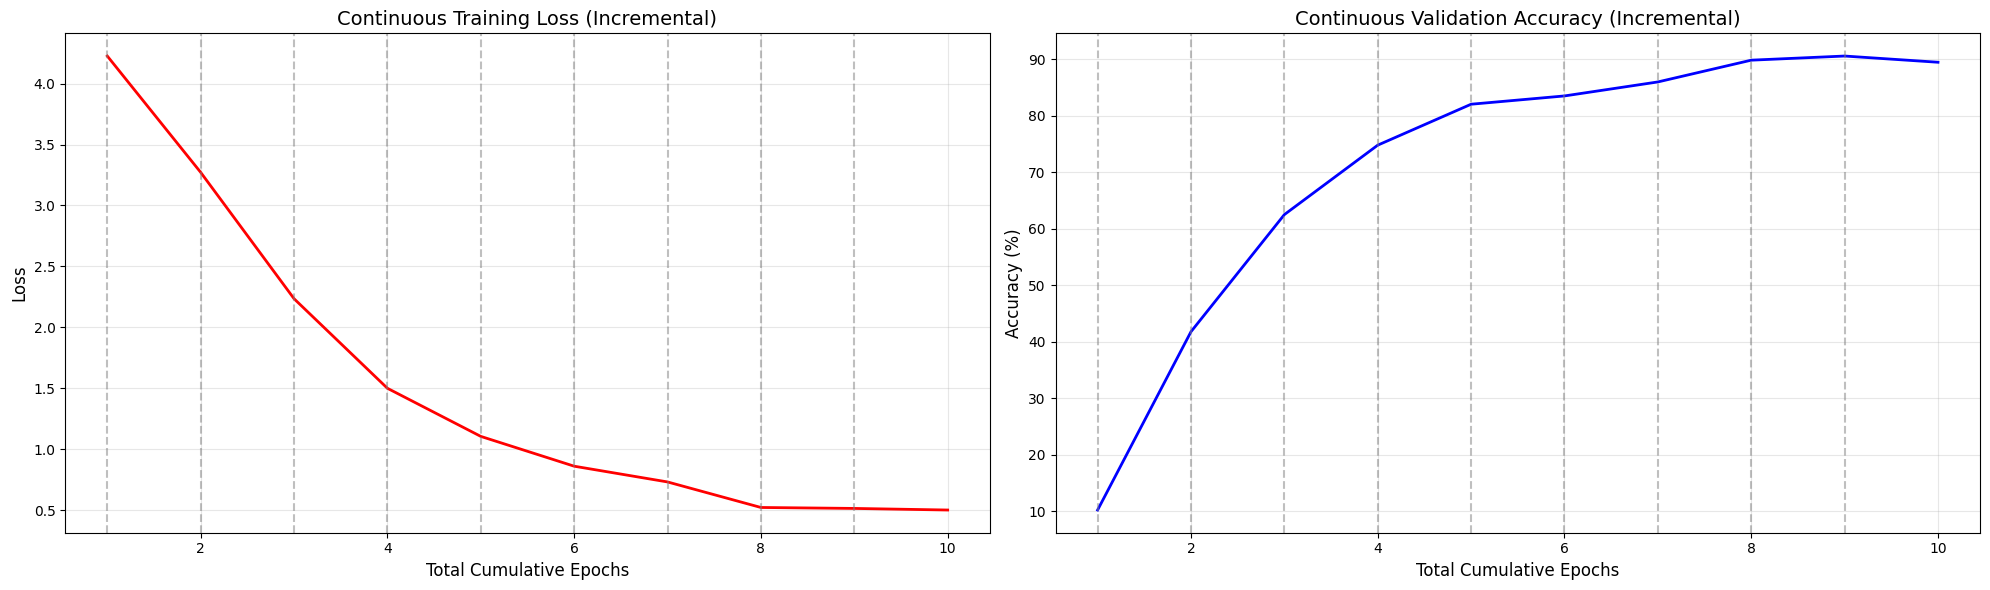

/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


✅ Графік відправлено в MLflow.


In [ ]:
project_root = "/content/yolo_incremental_stratified"
SAVE_TO_MLFLOW = True
mlflow_uri = "/content/runs/mlflow"
K_FOLDS = 10


print(f"🚀 Збираємо дані з усіх {K_FOLDS} фолдів в один графік...")

all_loss = []
all_acc = []
fold_boundaries = []
current_epoch_counter = 0

for i in range(1, K_FOLDS + 1):
    csv_path = os.path.join(project_root, f"fold_{i}", "results.csv")

    if not os.path.exists(csv_path):
        print(f"⚠️ Файл не знайдено: {csv_path}")
        continue

    try:
        df = pd.read_csv(csv_path)
        df.columns = [c.strip() for c in df.columns] # Чистимо назви

        if 'val/loss' in df.columns:
            all_loss.extend(df['val/loss'].tolist())

        if 'metrics/accuracy_top1' in df.columns:
            all_acc.extend(df['metrics/accuracy_top1'].tolist())

        current_epoch_counter += len(df)
        fold_boundaries.append(current_epoch_counter)

    except Exception as e:
        print(f"❌ Помилка читання fold_{i}: {e}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))


epochs_range = range(1, len(all_loss) + 1)


ax1.plot(epochs_range, all_loss, label='Train Loss', color='red', linewidth=2)
ax1.set_title('Continuous Training Loss (Incremental)', fontsize=14)
ax1.set_xlabel('Total Cumulative Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.grid(True, alpha=0.3)


for boundary in fold_boundaries[:-1]:
    ax1.axvline(x=boundary, color='gray', linestyle='--', alpha=0.5)

acc_percentage = [x * 100 for x in all_acc]
ax2.plot(epochs_range, acc_percentage, label='Val Accuracy', color='blue', linewidth=2)
ax2.set_title('Continuous Validation Accuracy (Incremental)', fontsize=14)
ax2.set_xlabel('Total Cumulative Epochs', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.grid(True, alpha=0.3)


for boundary in fold_boundaries[:-1]:
    ax2.axvline(x=boundary, color='gray', linestyle='--', alpha=0.5)


plt.tight_layout()


plot_path = "incremental_training_progress.png"
plt.savefig(plot_path)
print(f"✅ Графік збережено: {plot_path}")

plt.show()


if SAVE_TO_MLFLOW:
    mlflow.set_tracking_uri(mlflow_uri)
    mlflow.set_experiment("YOLO_Visualization")

    with mlflow.start_run(run_name="Incremental_Progress_Analysis"):
        mlflow.log_artifact(plot_path)
        print("✅ Графік відправлено в MLflow.")

In [ ]:
best_model_path = "/content/yolo_incremental_stratified_round2/fold_10/weights/best.pt"

print(f"⚖️ Завантажуємо найкращу YOLO модель з: {best_model_path}")

model = YOLO(best_model_path)


print("🎉 Модель успішно завантажена! Вона вже готова до роботи.")

model.info()

⚖️ Завантажуємо найкращу YOLO модель з: /content/yolo_incremental_stratified_round2/fold_10/weights/best.pt
🎉 Модель успішно завантажена! Вона вже готова до роботи.
YOLO11s-cls summary: 86 layers, 5,571,108 parameters, 0 gradients, 12.2 GFLOPs


(86, 5571108, 0, 12.2370048)

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from ultralytics import YOLO
from PIL import Image
import mlflow
import random
from tqdm import tqdm
import gc
import torch
from IPython.display import Image as IPImage, display # Для показу картинок


eval_source_dir = '/content/fast_data/train'
best_model_path = "/content/yolo_incremental_stratified_round2/fold_10/weights/best.pt"
mlflow_uri = "/content/mlruns_butterfly"


PYTHON_BATCH_SIZE = 200
YOLO_BATCH_SIZE = 32

mlflow.set_tracking_uri(mlflow_uri)
mlflow.set_experiment("YOLO_Final_Evaluation")

print(f"⚖️ Завантажуємо модель: {best_model_path}")
model = YOLO(best_model_path)

class_names = model.names
class_names_list = [class_names[i] for i in range(len(class_names))]

print(f"📊 Починаємо оцінку з візуалізацією...")

with mlflow.start_run(run_name="YOLO_Visual_Eval") as run:


    print("⏳ Скануємо файли...")
    all_files_info = []
    for root, dirs, files in os.walk(eval_source_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, file)
                true_label = os.path.basename(root)
                all_files_info.append((full_path, true_label))

    # Розділяємо на списки
    all_paths = [x[0] for x in all_files_info]
    all_true_labels = [x[1] for x in all_files_info]

    y_pred_str = []
    y_true_str = []
    image_paths_for_viz = []

    total_files = len(all_paths)

    for i in tqdm(range(0, total_files, PYTHON_BATCH_SIZE), desc="Processing chunks"):
        chunk_paths = all_paths[i : i + PYTHON_BATCH_SIZE]
        chunk_true_labels = all_true_labels[i : i + PYTHON_BATCH_SIZE]

        results = model.predict(chunk_paths, batch=YOLO_BATCH_SIZE, stream=False, verbose=False, device=0)

        for j, result in enumerate(results):
            top1_idx = result.probs.top1
            pred_label = result.names[top1_idx]

            y_pred_str.append(pred_label)
            y_true_str.append(chunk_true_labels[j])
            image_paths_for_viz.append(chunk_paths[j])

        del results
        gc.collect()
        torch.cuda.empty_cache()


    print("\n" + "="*40)
    print("📈 РЕЗУЛЬТАТИ ОЦІНКИ")
    print("="*40)

    acc = accuracy_score(y_true_str, y_pred_str)
    print(f"\n🏆 ЗАГАЛЬНА ТОЧНІСТЬ: {acc * 100:.2f}%")
    mlflow.log_metric("final_eval_accuracy", acc)

    print("\n📝 Звіт класифікації:")
    report = classification_report(y_true_str, y_pred_str, target_names=class_names_list)
    print(report) 

    report_path = "classification_report_safe.txt"
    with open(report_path, "w") as f:
        f.write(report)
    mlflow.log_artifact(report_path)

    print("\n🎨 Матриця плутанини:")
    cm = confusion_matrix(y_true_str, y_pred_str, labels=class_names_list)

    plt.figure(figsize=(22, 20))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_names_list, yticklabels=class_names_list)
    plt.title(f'YOLO Confusion Matrix (Acc: {acc:.2%})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    cm_path = "confusion_matrix_safe.png"
    plt.savefig(cm_path)
    plt.close()

    display(IPImage(filename=cm_path))

    mlflow.log_artifact(cm_path)

    print("\n🖼️ Приклади передбачень:")
    indices = random.sample(range(len(image_paths_for_viz)), 16)

    fig = plt.figure(figsize=(16, 16))
    for i, idx in enumerate(indices):
        ax = fig.add_subplot(4, 4, i + 1)
        path = image_paths_for_viz[idx]
        img = Image.open(path)

        true_lbl = y_true_str[idx]
        pred_lbl = y_pred_str[idx]
        col = 'green' if true_lbl == pred_lbl else 'red'

        ax.imshow(img)
        ax.set_title(f"T: {true_lbl}\nP: {pred_lbl}", color=col, fontsize=9, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    viz_path = "grid_safe.png"
    plt.savefig(viz_path)
    plt.close()

    display(IPImage(filename=viz_path))

    mlflow.log_artifact(viz_path)

print("\n🎉 Готово! Тепер ти бачиш все на власні очі.")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
test_dir = '/content/fast_data/test'
output_csv_path = '/content/submission_yolo_final.csv'


best_model_path = "/content/yolo_incremental_stratified_round2/fold_10/weights/best.pt"

PYTHON_BATCH_SIZE = 200  
YOLO_BATCH_SIZE = 32    


print("🧹 Очищення пам'яті перед стартом...")
gc.collect()
torch.cuda.empty_cache()

print(f"⚖️ Завантажуємо модель: {best_model_path}")
model = YOLO(best_model_path)

print("📂 Скануємо тестову папку...")
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"📸 Знайдено зображень: {len(test_files)}")

all_ids = []
all_preds = []

print(f"🚀 Починаємо обробку з TTA (augment=True)...")
print(f"ℹ️ Режим: Python Chunks={PYTHON_BATCH_SIZE}, YOLO Batch={YOLO_BATCH_SIZE}")

# Головний цикл по "чанках"
for i in tqdm(range(0, len(test_files), PYTHON_BATCH_SIZE), desc="Processing chunks"):
    chunk_paths = test_files[i : i + PYTHON_BATCH_SIZE]


    results = model.predict(
        chunk_paths,
        batch=YOLO_BATCH_SIZE,
        augment=False,   
        verbose=False,
        device=0,
        stream=False    
    )


    for result in results:
        filename = os.path.basename(result.path)
        file_id = os.path.splitext(filename)[0]


        top1_index = result.probs.top1
        pred_label = result.names[top1_index]

        all_ids.append(file_id)
        all_preds.append(pred_label)


    del results
    gc.collect()
    torch.cuda.empty_cache()


print("💾 Зберігаємо CSV...")
submission_df = pd.DataFrame({
    'id': all_ids,
    'label': all_preds
})

submission_df.to_csv(output_csv_path, index=False)

print(f"\n🎉 Готово! Файл збережено: {output_csv_path}")
print("Перші 5 рядків:")
print(submission_df.head())

🧹 Очищення пам'яті перед стартом...
⚖️ Завантажуємо модель: /content/yolo_incremental_stratified_round2/fold_10/weights/best.pt
📂 Скануємо тестову папку...
📸 Знайдено зображень: 2728
🚀 Починаємо обробку з TTA (augment=True)...
ℹ️ Режим: Python Chunks=200, YOLO Batch=32


Processing chunks: 100%|██████████| 14/14 [00:13<00:00,  1.00it/s]

💾 Зберігаємо CSV...

🎉 Готово! Файл збережено: /content/submission_yolo_final.csv
Перші 5 рядків:
                                 id                    label
0  aea4ce0521db4db2bf6be0cb5e47126d  WHITE LINED SPHINX MOTH
1  8429d6c8faa5428bbdd5557fd7e47462            HERCULES MOTH
2  d7dac4265b6c4aff9f9b772e98ef6237                LUNA MOTH
3  33ebf85ba9f44f8686a1c412237ed47c     ARCIGERA FLOWER MOTH
4  2dbfe7eecb4c43afbdfccf1c9e83e9b6          IPHICLUS SISTER
